In [1]:
generate_data = False

In [2]:
import numpy as np
import run_continuum as run
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import scipy.signal
import scipy as scp
import scipy.io as sio

import warnings
warnings.filterwarnings('ignore')

from frictionlaws import SlipWeakeningFrictionLaw
from predictions import *

import pickle

In [3]:
barrier_x = 40

if generate_data:
    data = []
    dt = 1e-3
    tmax = 400
    gamma = 0.0
    beta = 1e-3
    output_interval = 500
    x = np.linspace(0,300,30000)

    tau_all = np.logspace(-3,-1,25)
    tau_barrier_all = -np.logspace(-2,0,25)

    L_arrest = np.zeros([np.size(tau_all),np.size(tau_barrier_all)])
    L_arrest_pred = np.zeros([np.size(tau_all),np.size(tau_barrier_all)])

    for i in range(np.size(tau_all)):
        print(i)
        for j in range(np.size(tau_barrier_all)):

            tau = gauss(x,0,1)*(1-tau_all[i]) + tau_all[i]
            tau[0]=1
            tau[x>barrier_x]=tau_barrier_all[j]

            # run
            data = run.run_continuum(x = x, tau = tau, tau_minus = tau+2, dt = dt, output_interval = output_interval, gamma = gamma, tmax = tmax, beta = beta)
#            data.append()

            # Find L_arrest
            L_arrest[i,j]=x[np.max(np.where(data['u'][:,-1]>0))] - barrier_x

            # Find the arrest based on integral over tau
            dx = x[1]
            tmp = np.cumsum(tau)*dx
            if np.min(tmp)<0:
                L_arrest_pred[i,j] = x[np.where(tmp<0)][0] - barrier_x
            else:
                L_arrest_pred[i,j] = -1
    
    pickle.dump({'data': data, 'barrier_x': barrier_x, 'L_arrest': L_arrest, 'L_arrest_pred': L_arrest_pred, 'tau_all': tau_all, 'tau_barrier_all': tau_barrier_all, 'x': x},  open( "data/figure_crack_stress_barrier.p", "wb" ))        
else:
    data = pickle.load( open( "data/figure_crack_stress_barrier.p", "rb" ) )
    L_arrest = data['L_arrest']
    L_arrest_pred = data['L_arrest_pred']
    tau_all = data['tau_all']
    tau_barrier_all = data['tau_barrier_all']
    x = data['x']    
    data = data['data']
    


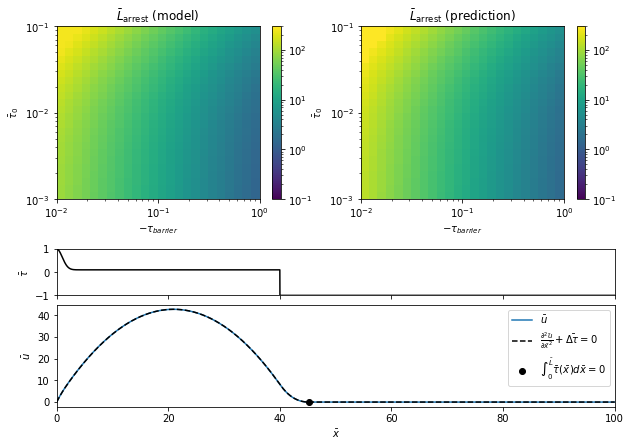

In [4]:
plt.figure(figsize=(10,7))

plt.subplot(2,2,1)
L = L_arrest
L[L<=1e-1]=1e-1
plt.pcolormesh(-tau_barrier_all,tau_all,L,norm=colors.LogNorm(vmin=1e-1, vmax=300))
plt.yscale('log')
plt.xscale('log')
plt.colorbar()
plt.xlabel('$-\\tau_{barrier}$')
plt.ylabel('$\\bar \\tau_0$')
plt.title('$\\bar L_\mathrm{arrest}$ (model)')

plt.subplot(2,2,2)
L = L_arrest_pred
L[L<0]=300
plt.pcolormesh(-tau_barrier_all,tau_all,L,norm=colors.LogNorm(vmin=1e-1, vmax=300))
plt.colorbar()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('$-\\tau_{barrier}$')
plt.ylabel('$\\bar \\tau_0$')
plt.title('$\\bar L_\mathrm{arrest}$ (prediction)')

# Plot slip example (only last point)
#plotind = -1
ax = plt.subplot(7,1,5)
tau = gauss(x,0,1)*(1-.1) + .1
tau[0]=1
tau[x>barrier_x]=-.3
plt.plot(data['x'],data['tau'], '-k',label='$\\bar \\tau$')
plt.xlabel('$\\bar x$')
plt.xlim([0,100])
plt.ylabel('$\\bar \\tau$')
plt.ylim([-1,1])
ax.set_xticklabels([])

plt.subplot(7,1,(6,7))
#data = run.run_continuum(x = x, tau = tau, tau_minus = tau+2, dt = dt, output_interval = output_interval, gamma = gamma, tmax = tmax, beta = beta)
u_pred, L_pred = CrackPrediction(u = data['u'], x = data['x'], a = data['a'][:,-1], tau = data['tau'], gamma = data['gamma'],dc = 0)
plt.plot(data['x'],data['u'][:,-1],label='$\\bar u$')
plt.plot(data['x'],u_pred,'--k',label = '$\\frac{\\partial ^2 \\bar u}{\\partial \\bar x^2} + \\bar {\\Delta \\tau} = 0$')
plt.plot(L_pred,0,'ok', label='$\\int_0^{\\bar L} \\bar \\tau (\\bar x) d \\bar x = 0$')
plt.xlabel('$\\bar x$')
plt.xlim([0,100])
plt.ylabel('$\\bar u$')    
plt.legend()

#plt.tight_layout()

#plt.savefig('figures/arrest_length_crack_tau.eps', format='eps')

plt.show()